In [8]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [55]:
df = pd.read_csv("vlc_positioning_dataset_2.csv")

In [56]:
df

,X,Y,LED1,LED2,LED3,LED4
0,4.07360,3.72430,0.000088,0.000012,0.000133,0.061205
1,4.52900,4.46130,0.000029,0.000008,0.000064,0.009562
2,0.63493,1.21300,0.018080,0.000016,0.000073,0.000096
3,4.56690,0.64798,0.000162,0.000002,0.002708,0.000281
4,3.16180,1.12530,0.000622,0.000007,0.001737,0.000400
...,...,...,...,...,...,...
1995,0.12575,1.03960,0.004333,0.000012,0.000046,0.000047
1996,2.07210,0.19802,0.001693,0.000005,0.000246,0.000113
1997,3.65700,2.34680,0.000266,0.000011,0.000615,0.001607
1998,3.90690,0.75048,0.000296,0.000003,0.017587,0.000325


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       2000 non-null   float64
 1   Y       2000 non-null   float64
 2   LED1    2000 non-null   float64
 3   LED2    2000 non-null   float64
 4   LED3    2000 non-null   float64
 5   LED4    2000 non-null   float64
dtypes: float64(6)
memory usage: 93.9 KB


In [58]:
df.isnull().sum()

X       0
Y       0
LED1    0
LED2    0
LED3    0
LED4    0
dtype: int64

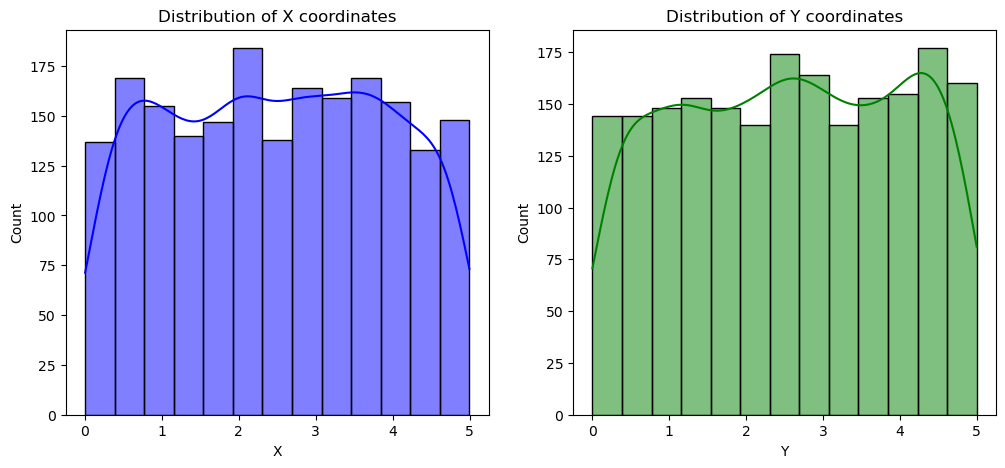

In [59]:
# Plot the distribution of X and Y coordinates
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(df['X'], kde=True, color='blue')
plt.title('Distribution of X coordinates')

plt.subplot(1,2,2)
sns.histplot(df['Y'], kde=True, color='green')
plt.title('Distribution of Y coordinates')

plt.show()

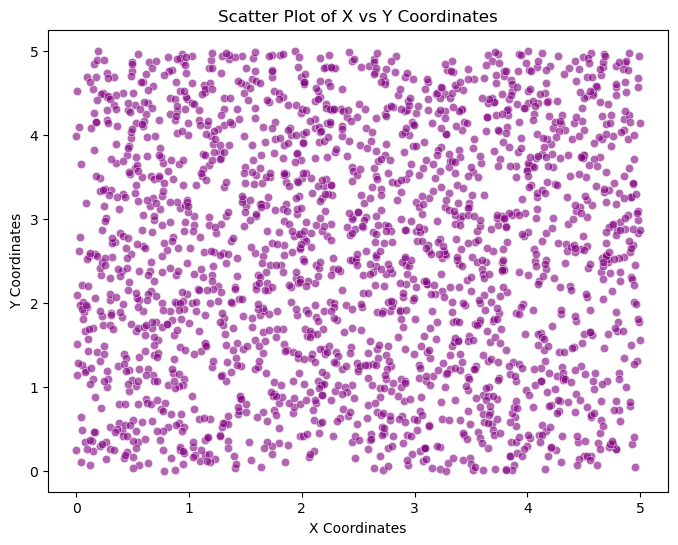

In [60]:
# Scatter plot of X vs Y coordinates
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['X'], y=df['Y'], alpha=0.6, color='purple')
plt.title('Scatter Plot of X vs Y Coordinates')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.show();

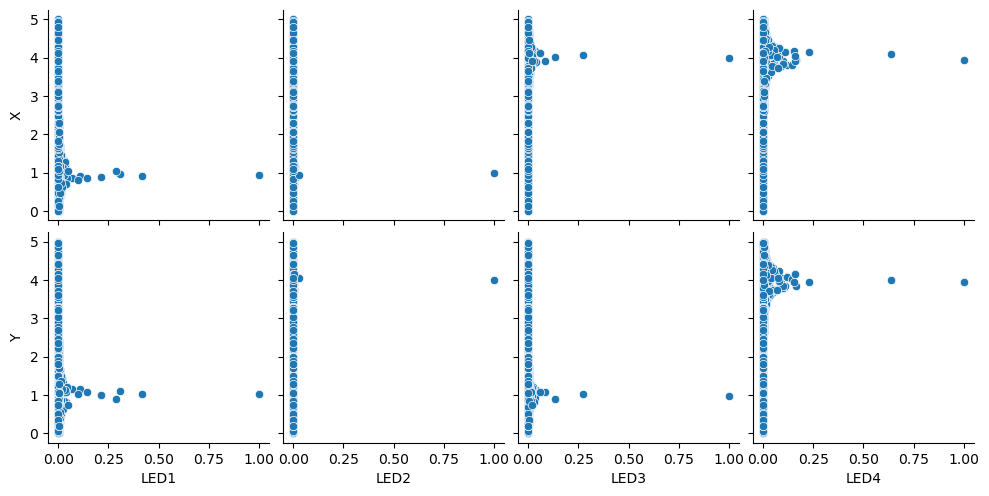

In [61]:
# Pairplot to visualize relationships between RSS values and coordinates
sns.pairplot(df, x_vars=['LED1', 'LED2', 'LED3', 'LED4'], y_vars=['X', 'Y'], kind='scatter')
plt.show();

In [62]:
#features (RSS Values)
X = df[['LED1', 'LED2', 'LED3', 'LED4']]

#labels (X,Y coordinates)
y = df[['X', 'Y']]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training features shape: (1600, 4)
Testing features shape: (400, 4)
Training labels shape: (1600, 2)
Testing labels shape: (400, 2)


In [64]:
##param_grid = {
    #'n_estimators': [50, 100, 200],
    #'max_depth': [None, 10, 20, 30],
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4],
    #'max_features': ['log2', 'sqrt']
#}

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                          cv=5, scoring='neg_mean_squared_error',
                          verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 640 candidates, totalling 3200 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [65]:
best_rf = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42
)

best_rf.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=300, random_state=42)

In [66]:
y_pred_tuned = best_rf.predict(X_test)

mae_x_tuned = mean_absolute_error(y_test['X'], y_pred_tuned[:, 0])
rmse_x_tuned = np.sqrt(mean_squared_error(y_test['X'], y_pred_tuned[:, 0]))
r2_x_tuned = r2_score(y_test['X'], y_pred_tuned[:, 0])

mae_y_tuned = mean_absolute_error(y_test['Y'], y_pred_tuned[:, 1])
rmse_y_tuned = np.sqrt(mean_squared_error(y_test['Y'], y_pred_tuned[:, 1]))
r2_y_tuned = r2_score(y_test['Y'], y_pred_tuned[:, 1])

print(f"Tuned Model - X Coordinate Metrics:")
print(f"MAE: {mae_x_tuned}")
print(f"RMSE: {rmse_x_tuned}")
print(f"R² Score: {r2_x_tuned}")

print(f"\nTuned Model - Y Coordinate Metrics:")
print(f"MAE: {mae_y_tuned}")
print(f"RMSE: {rmse_y_tuned}")
print(f"R² Score: {r2_y_tuned}")

Tuned Model - X Coordinate Metrics:
MAE: 0.020615681574999857
RMSE: 0.037683174232920606
R² Score: 0.9992940983754242

Tuned Model - Y Coordinate Metrics:
MAE: 0.020805866479167327
RMSE: 0.03710607176806504
R² Score: 0.9993318609131993


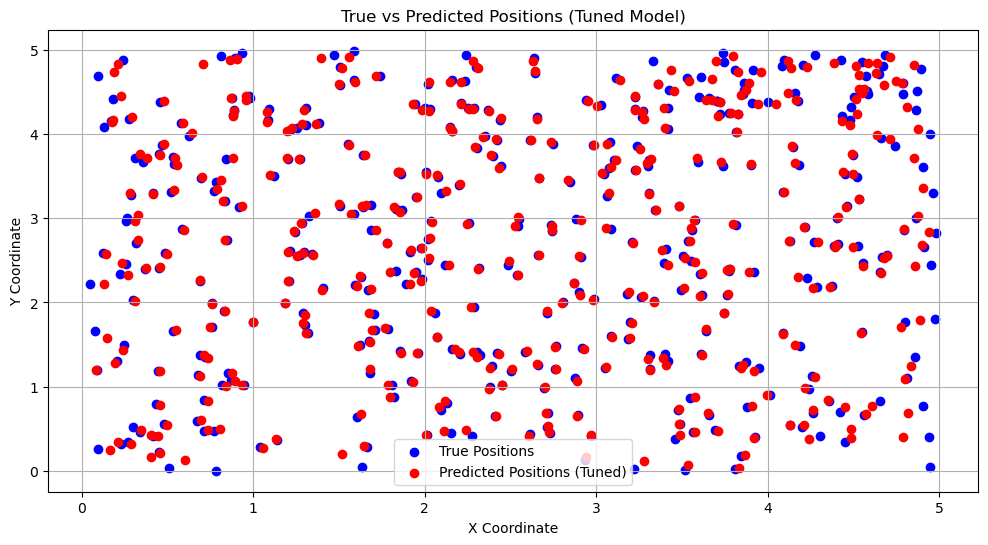

In [67]:
# Plot true vs predicted positions for the tuned model
plt.figure(figsize=(12, 6))
plt.scatter(y_test['X'], y_test['Y'], color='blue', label='True Positions')
plt.scatter(y_pred_tuned[:, 0], y_pred_tuned[:, 1], color='red', label='Predicted Positions (Tuned)')
plt.title('True vs Predicted Positions (Tuned Model)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
joblib.dump(best_rf, 'tuned_random_forest_position_predictor.pkl')

['tuned_random_forest_position_predictor.pkl']